# Рекомендательные системы
Выполнил работу **Пакало Александр Сергеевич**, студент РТ5-61Б

# Цель работы
Необходимо предложить пользователям Яндекс.Карт соответствующие их вкусу
кафе, бары и рестораны в неродном городе: москвичам – в Санкт-Петербурге, а
петербуржцам – в Москве. В качестве данных предоставлена анонимизированная
информация о реальных отзывах и оценках, оставляемых пользователями
Яндекс.Карт на заведения общепита Москвы и Санкт-Петербурга, и различная
информация о самих заведениях.

В частности, каждый отзыв содержит множество
аспектов (упомянутые в отзыве блюда, особенности и т. п.), извлеченных из
отзыва с помощью NLP-алгоритма. Для заданного множества москвичей и
петербуржцев нужно предсказать, какие заведения в неродном городе они
посетят, оставив при этом положительный отзыв с оценкой 4 или 5.

Так как данных очень много, перед тем как приступить к анализу, проведем обзор данных и, возможно, потребуется их предобработка, чтобы датасет стал более удобным и пригодным к проведению исследования.

Таким образом исследование пройдет в 6 этапов:
- загрузка данных,
- проведение разведочного анализа данных и предобработка данных,
- разделение на обучающую и тестовую выборку,
- выбор метрики,
- подбор рекомендаций с помощью различных моделей,
- анализ результатов моделей на основе метрики.

# Импорт библиотек

In [46]:
# Основные библиотеки.
import numpy as np
import pandas as pd

# Визуализция.
import matplotlib.pyplot as plt
import seaborn as sns

# Для матрицы взаимодействий.
from scipy import sparse

# Отрисовка статуса выполнения.
from tqdm.notebook import tqdm

# Типизация.
from typing import List

# Настройки отрисовки графиков.
%matplotlib inline

# Загрузка данных

## Считываем данные из .csv
Загрузим файлы датасета в помощью библиотеки Pandas.

Не смотря на то, что файлы имеют расширение txt они представляют собой данные
в формате [CSV](https://ru.wikipedia.org/wiki/CSV). Часто в файлах такого
формата в качестве разделителей используются символы ",", ";" или табуляция.
Поэтому вызывая метод read_csv всегда стоит явно указывать разделитель данных
с помощью параметра sep. Чтобы узнать какой разделитель используется в файле
его рекомендуется предварительно посмотреть в любом текстовом редакторе.

В первую очередь нам понадобятся данные по **пользователям**, **организациям** и сами **отзывы**. 

In [47]:
users = pd.read_csv('data/users.csv', sep=',')

In [48]:
orgs = pd.read_csv('data/organisations.csv', sep=',')

In [49]:
# Читаем датасет по частям, затем соединяем в один. Позволяет загружать большие
#   (500 мб и более) датасеты.
#   К сожалению, даже при low_memory=True иногда падает кернел, несмотря на то
#   что внутри используется схожий механизм.
# - Количество рядов, содеражихся в одной части датасета.
chunksize = 1000
reviews = pd.concat(pd.read_csv('data/reviews.csv', chunksize=chunksize))

# Проведение разведочного анализа данных. Построение графиков, необходимых для понимания структуры данных. Анализ и предобработка данных.

Размеры датасетов:
- Пользователи - 1.250.944 строк, 2 колонки.
- Организации - 66.346 строк, 6 колонок.
- Отзывы - 3.642.383 строк, 5 колонок.

In [50]:
users.shape, orgs.shape, reviews.shape

((1250994, 2), (66346, 6), (3642383, 5))

Общий вид данных таблицы пользователей:

In [51]:
users.head()

,user_id,city
0,36BF53FF2D117FD6B70F11C1C2D2DD88609298CBF80A11...,msk
1,37C79862F940ED4A451304697F61E652FE120C868BBCD5...,msk
2,40279525A675CB54040C01C09A5AEE02794B187E24C204...,msk
3,40DD4DBAEFF1376F92DA3E08D36E3E81A2539228389143...,msk
4,FB01CDD7C500F53CB666EA7B182A5BB940271FCC9BF039...,msk


Список колонок:

In [52]:
users.columns

Index(['user_id', 'city'], dtype='object')

Список колонок с типами данных:

In [53]:
users.dtypes

user_id    object
city       object
dtype: object

Общий вид данных таблицы организаций:

In [54]:
orgs.head()

,org_id,city,average_bill,rating,rubrics_id,features_id
0,DB02713EAD474F7DCB4FAB65333D4D360C6337BFC3CA43...,msk,500.0,4.378378,30771,1509 10462 11617 273469383 1082283206 1018 152...
1,31F077980B0BCC05B17B988E0017B538CE523A2ACB8FEA...,msk,500.0,4.166667,30519,1524 10462 11177 11629 1018 11704 1415 11867 2...
2,B16CB024197B053E9C713A79812ED658CA4B2FB8F5293C...,msk,500.0,3.687500,30776 30771,1524 11629 1018 11704 10462 12048 1416 246 204...
3,25308E05A46D9D40BDB6A6AC55CD422147D40B0B0D44B2...,msk,500.0,3.835417,30771,10462 3501744275 3501513153 20424 3501618484 2...
4,D9FB72E2B38AC2A03586074A0019ABA16F7EE761C08120...,msk,500.0,4.750000,3501750896,20282 20424 273469383 11617 11629 11177 10462 ...


Список колонок:

In [55]:
orgs.columns

Index(['org_id', 'city', 'average_bill', 'rating', 'rubrics_id',
       'features_id'],
      dtype='object')

Список колонок с типами данных:

In [56]:
orgs.dtypes

org_id           object
city             object
average_bill    float64
rating          float64
rubrics_id       object
features_id      object
dtype: object

Общий вид данных таблицы рекомендаций:

In [57]:
reviews.head()

,user_id,org_id,rating,ts,aspects
0,E5A7AF2BBA62183E969998FFE09A6304F4761BC7445EF8...,689F4C0B84691F6FC69368EDF6E426BEAC543C799F56F2...,5.0,618,NaN
1,26B8CB030A2B279E6804AC6EF20C27D7F7BE0C08129C78...,01074FAE0B11E5A1B74AC2D82CF0B66F2A766C84856B0D...,5.0,525,38 326 8
2,A563C39DB5FE7418D9A6DFE2B412B5D56D94354F57A249...,A9B175ABD408F9C22A1E5DBE40FA1E12A19AB0DB632555...,3.0,992,NaN
3,C3EBA3C3B06DF6D4660FA05F89E6FDC9064AEE854E0F42...,EB920597A31D5A076FE047DEA1B1B5270C2C69A2D4E1FB...,1.0,743,NaN
4,31F3248779160242FDF7382C945F296F236762E53930BB...,61CA13C754EE92C2CAEA47987DEC07889AFD53C52753D6...,4.0,629,NaN


Список колонок:

In [58]:
reviews.columns

Index(['user_id', 'org_id', 'rating', 'ts', 'aspects'], dtype='object')

Список колонок с типами данных:

In [59]:
reviews.dtypes

user_id     object
org_id      object
rating     float64
ts           int64
aspects     object
dtype: object

Некоторые данные (такие как рубрики и признаки), представлены строками
значений. Для удобства анализа преобразуем их в списки чисел. 

In [60]:
# Переводит строку вида '1 2 3 4' в список [1, 2, 3, 4].
to_int_list = lambda values: [int(value) for value in str(values).split(' ')]

def apply_to_columns(df: pd.DataFrame, columns: List[str], func=to_int_list):
    """
    apply_to_columns(df: pd.DataFrame, columns: List[str], func=to_int_list)
        Применяет функцию к заданным колонкам <columns> датасета <df>.
    """

    for column in columns:
        df.loc[~df[column].isnull(), column] = df.loc[
            ~df[column].isnull(), column
        ].apply(func)

In [61]:
# Переводим рубрики и признаки в удобный вид.
columns = ['rubrics_id', 'features_id']
apply_to_columns(orgs, columns)

orgs.head()

,org_id,city,average_bill,rating,rubrics_id,features_id
0,DB02713EAD474F7DCB4FAB65333D4D360C6337BFC3CA43...,msk,500.0,4.378378,[30771],"[1509, 10462, 11617, 273469383, 1082283206, 10..."
1,31F077980B0BCC05B17B988E0017B538CE523A2ACB8FEA...,msk,500.0,4.166667,[30519],"[1524, 10462, 11177, 11629, 1018, 11704, 1415,..."
2,B16CB024197B053E9C713A79812ED658CA4B2FB8F5293C...,msk,500.0,3.687500,"[30776, 30771]","[1524, 11629, 1018, 11704, 10462, 12048, 1416,..."
3,25308E05A46D9D40BDB6A6AC55CD422147D40B0B0D44B2...,msk,500.0,3.835417,[30771],"[10462, 3501744275, 3501513153, 20424, 3501618..."
4,D9FB72E2B38AC2A03586074A0019ABA16F7EE761C08120...,msk,500.0,4.750000,[3501750896],"[20282, 20424, 273469383, 11617, 11629, 11177,..."


Чтобы не делать __join__ каждый раз, когда нам потребуется узнать, из какого
города организация или пользователь, сразу добавим эту информацию в отзывы.

In [62]:
# Join по user_id.
reviews = reviews.merge(users, on='user_id')
reviews = reviews.rename({'city': 'user_city'}, axis=1)

# Join по org_id.
reviews = reviews.merge(orgs[['org_id', 'city']], on='org_id')
reviews = reviews.rename({'city': 'org_city'}, axis=1)

# В колонке aspects тоже находятся записи вида '1 2 3', приведём их к числовому
#   списку.
columns = ['aspects']
apply_to_columns(reviews, columns)

reviews.head()

,user_id,org_id,rating,ts,aspects,user_city,org_city
0,E5A7AF2BBA62183E969998FFE09A6304F4761BC7445EF8...,689F4C0B84691F6FC69368EDF6E426BEAC543C799F56F2...,5.0,618,NaN,msk,msk
1,9EE61FA268028BF20A1B320A880A39C8980D3744818773...,689F4C0B84691F6FC69368EDF6E426BEAC543C799F56F2...,5.0,817,NaN,msk,msk
2,CD2B195CD844F1288549EA7FC328AD45D8CAB75CA774D0...,689F4C0B84691F6FC69368EDF6E426BEAC543C799F56F2...,5.0,514,NaN,msk,msk
3,77355B0BE48A8AE2CD32D7344DB51B86ECD585CAC920CA...,689F4C0B84691F6FC69368EDF6E426BEAC543C799F56F2...,3.0,1080,NaN,msk,msk
4,FE35FCFAA71FFA5B3E8E8A91B7A8676D5AC89A474DC9DA...,689F4C0B84691F6FC69368EDF6E426BEAC543C799F56F2...,5.0,776,NaN,msk,msk


Отлично, теперь с отзывами будет удобно работать. 

# # Построение графиков для понимания структуры данных
Посмотрим на распределение новых отзывов по дням, чтобы понять, как лучше организовать валидацию. 

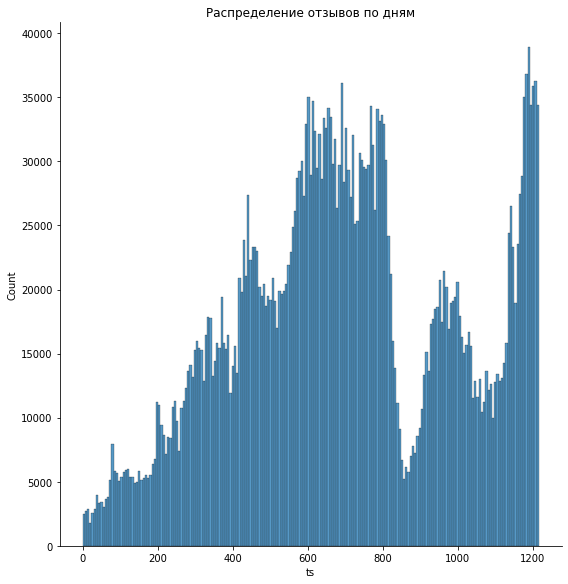

In [63]:
sns.displot(data=reviews, x='ts', height=8)
plt.title('Распределение отзывов по дням')
plt.show()

Всего в выборку попали отызывы за **1216** дней. 

In [64]:
reviews['ts'].max()

1216

# Выделение обучающей и тестовой выборки
В качестве обучающей выборки можно взять некоторый процент от всех данных,
однако намного эффективнее и более приближено к реальности разделение по
времени [1, стр. 232].

Отложим в тестовую выборку отзывы за последние **100** дней.

In [65]:
def clear_df(df, suffixes=['_x', '_y'], inplace=True):
    '''
    clear_df(df, suffixes=['_x', '_y'], inplace=True)
        Удаляет из входного df все колонки, оканчивающиеся на заданные суффиксы. 
        
        Parameters
        ----------
        df : pandas.DataFrame
        
        suffixies : Iterable, default=['_x', '_y']
            Суффиксы колонок, подлежащих удалению
            
        inplace : bool, default=True
            Нужно ли удалить колонки "на месте" или же создать копию DataFrame.
            
        Returns
        -------
        pandas.DataFrame (optional)
            df с удалёнными колонками
    '''
    
    def bad_suffix(column):
        nonlocal suffixes
        return any(column.endswith(suffix) for suffix in suffixes)
        
    columns_to_drop = [col for col in df.columns if bad_suffix(col)]
    return df.drop(columns_to_drop, axis=1, inplace=inplace)


def extract_unique(reviews, column): 
    '''
    extract_unique(reviews, column)
        Извлекает уникальные значения из колонки в DataFrame.
        
        Parameters
        ----------
        reviews : pandas.DataFrame
            pandas.DataFrame, из которого будут извлечены значения.
        
        column : str
            Имя колонки в <reviews>.
        
        Returns
        -------
        pandas.DataFrame
            Содержит одну именованную колонку с уникальными значениями. 
    '''
    
    unique = reviews[column].unique()
    return pd.DataFrame({column: unique})


def count_unique(reviews, column):
    '''
    count_unique(reviews, column)
        Извлекает и подсчитывает уникальные значения из колонки в DataFrame.
        
        Parameters
        ----------
        reviews : pandas.DataFrame
            pandas.DataFrame, из которого будут извлечены значения.
        
        column : str
            Имя колонки в <reviews>.
        
        Returns
        -------
        pandas.DataFrame
            Содержит две колонки: с уникальными значениями и счётчиком встреченных. 
    '''
    
    return reviews[column].value_counts().reset_index(name='count').rename({'index': column}, axis=1)



def filter_reviews(reviews, users=None, orgs=None): 
    '''
    filter_reviews(reviews, users=None, orgs=None)
    Оставляет в выборке только отзывы, оставленные заданными пользователями на заданные организации. 
    
    Parameters
    ----------
        users: pandas.DataFrame, default=None
            DataFrame, содержащий колонку <user_id>.
            Если None, то фильтрация не происходит. 
            
        orgs: pandas.DataFrame, default=None
            DataFrame, содержащий колонку <org_id>.
            Если None, то фильтрация не происходит. 
    
    Returns
    -------
        pandas.DataFrame
            Отфильтрованная выборка отзывов. 

    '''
    if users is not None: 
        reviews = reviews.merge(users, on='user_id', how='inner')
        clear_df(reviews)
        
    if orgs is not None:
        reviews = reviews.merge(orgs, on='org_id', how='inner')
        clear_df(reviews)
        
    return reviews


def train_test_split(reviews, ts_start, ts_end=None):
    '''
    train_test_split(reviews, ts_start, ts_end=None)
        Разделяет выборку отзывов на две части: обучающую и тестовую. 
        В тестовую выборку попадают только отзывы с user_id и org_id, встречающимися в обучающей выборке.

        Parameters
        ----------
        reviews : pandas.DataFrame 
            Отзывы из reviews.csv с обязательными полями:
                <rating>, <ts>, <user_id>, <user_city>, <org_id>, <org_city>.

        ts_start : int
            Первый день отзывов из тестовой выборки (включительно).

        ts_end : int, default=None
            Последний день отзывов из обучающей выборки (включительно)
            Если параметр равен None, то ts_end == reviews['ts'].max(). 

        Returns
        -------
        splitting : tuple
            Кортеж из двух pandas.DataFrame такой же структуры, как и reviews:
            в первом отзывы, попавшие в обучающую выборку, во втором - в тестовую.
    '''
    
    if not ts_end:
        ts_end = reviews['ts'].max()
    
    
    reviews_train = reviews[(reviews['ts'] < ts_start) | (reviews['ts'] > ts_end)]
    reviews_test = reviews[(ts_start <= reviews['ts']) & (reviews['ts'] <= ts_end)]
    
    # 1. Выбираем только отзывы на понравившиеся места у путешественников.
    reviews_test = reviews_test[reviews_test['rating'] >= 4.0]
    user_and_org_from_different_cities = reviews_test['org_city'] != reviews_test['user_city']
    reviews_test = reviews_test[user_and_org_from_different_cities]
    
    # 2. Оставляем в тесте только тех пользователей и организации, которые
    #   встречались в трейне.
    train_orgs = extract_unique(reviews_train, 'org_id')
    train_users = extract_unique(reviews_train, 'user_id')
    
    reviews_test = filter_reviews(reviews_test, orgs=train_orgs)

    return reviews_train, reviews_test


def process_reviews(reviews):
    '''
    process_reviews(reviews)
        Извлекает из набора отзывов тестовых пользователей и таргет. 
        
        Parameters
        ----------
        reviews : pandas.DataFrame
            DataFrame с отзывами, содержащий колонки <user_id> и <org_id>
        
        Returns
        -------
        X : pandas.DataFrame
            DataFrame такой же структуры, как и в test_users.csv
            
        y : pandas.DataFrame
            DataFrame с колонками <user_id> и <target>. 
            В <target> содержится список org_id, посещённых пользователем. 
    '''
    
    y = reviews.groupby('user_id')['org_id'].apply(list).reset_index(name='target')
    X = pd.DataFrame(y['user_id'])
    
    return X, y

In [66]:
train_reviews, test_reviews = train_test_split(reviews, 1116)
X_test, y_test = process_reviews(test_reviews)

Посмотрим, сколько всего уникальных пользователей попало в эту тестовую выборку:

In [67]:
len(X_test)

11978

# Выбор метрики
Для последующей оценки качества следует выбрать метрику.

Метрика **Precision**:

Доля верно предсказанных классификатором положительных объектов, из всех
объектов, которые классификатор верно или неверно определил как
положительные.
Принимает на вход два DataFrame, имеющих такую же структуру, как и **y_test**.
В контексте рекомендательных систем формула выглядит
следующим образом: 
$$
\begin{align*}
  \qquad P = \frac{\textrm{Количество релевантных рекомендаций}}{\textrm{Количество рекомендаций}}
\end{align*}
$$
К сожалению, данная метрика не учитывает порядок рекомендаций. Нам же хочется
предлагать пользователю в первую очередь те места, в которых мы наиболее
уверены. Для этого лучше предназначены следующие метрики [2]:

**Average Precision**:

$$
\begin{align*}
  \textrm{AP@N} = \frac{1}{m}\sum_{k=1}^N \textrm{($P(k)$ если $k_{ая}$ рекомендация была релевантна)} = \frac{1}{m}\sum_{k=1}^N P(k)\cdot rel(k),
\end{align*}
$$
где m - количество рекомендаций, N - количество рекомендаций, которые мы
берём в расчёт $ N \leq m $.

В конечном итоге, нас интересует **Mean Average Precision**  - среднее Average
Precision по пользователям:
$$
\begin{align*}
  \textrm{MAP@N} = \frac{1}{|U|}\sum_{u=1}^|U|(\textrm{AP@N})_u = \frac{1}{|U|} \sum_{u=1}^|U| \frac{1}{m}\sum_{k=1}^N P_u(k)\cdot rel_u(k).
\end{align*}
$$

In [68]:
def mean_average_precision_at_n(size=20):
    '''
    mean_average_precision_at_n(size=20)
        Создаёт метрику под <size> сделанных предсказаний.
        
        Parameters
        ----------
        size : int, default=20
            Размер рекомендованной выборки для каждого пользователя
        
        Returns
        -------
        func(pd.DataFrame, pd.DataFrame) -> float
            Функция, вычисляющая mean_average_precision_at_n.
        
    '''
    
    assert size >= 1, "Size must be greater than zero!"
    
    def metric(y_true, predictions, size=size):
        '''
        metric(y_true, predictions, size=size)
            Метрика mean_average_precision_at_n для двух перемешанных наборов <y_true> и <y_pred>.
            
            Parameters
            ----------
            y_true : pd.DataFrame
                DataFrame с колонками <user_id> и <target>. 
                В <target> содержится список настоящих org_id, посещённых пользователем. 
                
            predictions : pd.DataFrame
                DataFrame с колонками <user_id> и <target>. 
                В <target> содержится список рекомендованных для пользователя org_id.
                
            Returns
            -------
            float 
                Значение метрики.
        '''
        
        y_true = y_true.rename({'target': 'y_true'}, axis='columns')
        predictions = predictions.rename({'target': 'predictions'}, axis='columns')
        
        merged = y_true.merge(predictions, left_on='user_id', right_on='user_id')
    
        def average_precision_for_user(x: pd.DataFrame, size=size) -> float:
            '''
            average_precision_for_user(x: pd.DataFrame, size=size) -> float
            Средняя точность для пользователя.

            Parameters
            ----------
            x : pd.DataFrame
                DataFrame с колонками <user_id>, <y_true>, <predictions>.

            Returns
            -------
            float
                Значение от 0 до 1 - средняя точность для пользователя.
            '''
            y_true = x[1][1]
            predictions = x[1][2]
            
            weight = 0
            
            inner_weights = [0]
            for n, item in enumerate(predictions):
                inner_weight = inner_weights[-1] + (1 if item in y_true else 0)
                inner_weights.append(inner_weight)
            
            for n, item in enumerate(predictions):                
                if item in y_true:
                    weight += inner_weights[n + 1] / (n + 1)
                    
            return weight / min(len(y_true), size)

        return np.mean([average_precision_for_user(user_row) for user_row in merged.iterrows()])
    
        
    return metric


def print_score(score):
    print(f"Score: {score:.6f}")
    
    
N = 20
mapN = mean_average_precision_at_n(N)

# Подбор рекомендаций
Выделяют несколько типов таких систем, которые можно разделить по подходу к рекомендациям [1]:
1. Content-based
Пользователю рекомендуются объекты, похожие на те, которые этот пользователь уже использовал или просматривал ранее.
Степень схожести объектов оценивается по их характеристикам.

2. Коллаборативная фильтрация (Collaborative Filtering)
Пользователю рекомендуются объекты, подобранные в соответствии с оценками, поставленными ранее.
Для рекомендации используется история оценок как самого пользователя, так и других пользователей.
Данный подход основан на оценках, которые поставили пользователи. Он считается наиболее простым в реализации и чаще всего используется в недорогих рекомендательных системах.
Для рекомендации пользователю достопримечательности предсказываются оценки,
которые он может поставить, и выбираются места с наилучшими оценками.
Существует два способа реализации коллаборативной фильтрации [1]:
- User-based: здесь определяются пользователи, наиболее похожие по оценкам на того, которому составляется рекомендация, и в соответствии с их оценками предсказываются оценки текущего пользователя.
- Item-based: этот способ похож на User-based. Разница же заключается в том, что здесь
определяются места, наиболее похожие по оценкам на место, оценку которого мы
хотим предсказать. В соответствии с оценками этих мест предсказывается оценка
на данную достопримечательность.
Разрабатываемые системы, основанные User-based и Item-based коллаборативной
фильтрации, будут рекомендовать пользователям места, которым пользователи поставили бы наивысшую оценку.

3. Гибридные системы
Этот подход представляет собой совокупность двух предыдущих.

Результаты будем записывать в словарь:

In [69]:
results = {}

# Подходы без машинного обучения

## Случайные N мест

Попробуем предлагать пользователям случайные места из другого города. 

In [70]:
spb_orgs = orgs[orgs['city'] == 'spb']['org_id']
msk_orgs = orgs[orgs['city'] == 'msk']['org_id']

test_users_with_locations = X_test.merge(users, on='user_id')

In [71]:
%%time

np.random.seed(1337)
choose = lambda x: np.random.choice(spb_orgs, N) if x['user_id'] == 'msk' else np.random.choice(msk_orgs, N)
target = test_users_with_locations.apply(choose, axis=1)

predictions = X_test.copy()
predictions['target'] = target

mapN_random_result = mapN(y_test, predictions)
results['random'] = mapN_random_result
print_score(mapN_random_result)

Score: 0.000035
CPU times: user 1.66 s, sys: 0 ns, total: 1.66 s
Wall time: 1.65 s


## N самых популярных мест

Предыдущий подход, очевидно, не очень удачно предсказывает, какие места посетит пользователей. 

Попробуем улучшить стратегию: будем предлагать пользователям самые популярные места, то есть те, на которые оставлено больше всего отзывов. 

In [72]:
msk_orgs = train_reviews[(train_reviews['rating'] >= 4) & (train_reviews['org_city'] == 'msk')]['org_id']
msk_orgs = msk_orgs.value_counts().index[:N].to_list()

spb_orgs = train_reviews[(train_reviews['rating'] >= 4) & (train_reviews['org_city'] == 'spb')]['org_id']
spb_orgs = spb_orgs.value_counts().index[:N].to_list()

In [73]:
%%time

choose = lambda x: spb_orgs if x['user_id'] == 'msk' else msk_orgs
target = test_users_with_locations.apply(choose, axis=1)

predictions = X_test.copy()
predictions['target'] = target

mapN_popularity_result = mapN(y_test, predictions)
results['popularity'] = mapN_popularity_result
print_score(mapN_popularity_result)

Score: 0.004885
CPU times: user 879 ms, sys: 18.9 ms, total: 898 ms
Wall time: 884 ms


Отлично, метрика немного улучшилась. Но стоит попробовать доработать эту тактику. 

## N самых популярных мест среди туристов

In [74]:
tourist_reviews = train_reviews[train_reviews['rating'] >= 4.0]

# набор отзывов только от туристов
tourist_reviews = tourist_reviews[tourist_reviews['user_city'] != tourist_reviews['org_city']]

# выбираем самые популярные места среди туристов из Москвы и Питера
msk_orgs = tourist_reviews[tourist_reviews['org_city'] == 'msk']['org_id']
msk_orgs = msk_orgs.value_counts().index[:N].to_list()

spb_orgs = tourist_reviews[tourist_reviews['org_city'] == 'spb']['org_id']
spb_orgs = spb_orgs.value_counts().index[:N].to_list()

In [75]:
%%time

choose = lambda x: spb_orgs if x['user_id'] == 'msk' else msk_orgs
target = test_users_with_locations.apply(choose, axis=1)

predictions = X_test.copy()
predictions['target'] = target

mapN_tourist_popularity_result = mapN(y_test, predictions)
results['tourist_popularity'] = mapN_tourist_popularity_result
print_score(mapN_tourist_popularity_result)

Score: 0.008885
CPU times: user 818 ms, sys: 16.8 ms, total: 835 ms
Wall time: 830 ms


Метрика улучшилась ещё немного.

## N / rubrics_count самых популярных мест из каждой рубрики

In [76]:
def extract_top_by_rubrics(reviews, N):
    '''
    extract_top_by_rubrics(reviews, N)
        Набирает самые популярные организации по рубрикам, сохраняя распределение.
        
        Parameters
        ----------
        reviews : pd.DataFrame
            Отзывы пользователей для рекомендации.
            
        N : int
            Число рекомендаций.
        
        Returns
        -------
        orgs_list : list
            Список отобранных организаций.
    '''
    
    # Извлечение популярных рубрик.
    reviews = reviews.merge(orgs, on='org_id')[['org_id', 'rubrics_id']]
    
    rubrics = reviews.explode('rubrics_id').groupby('rubrics_id').size()
    rubrics = (rubrics / rubrics.sum() * N).apply(round).sort_values(ascending=False)

    # Вывод списка рубрик по убыванию популярности.
    print(
        pd.read_csv('data/rubrics.csv', sep=',')
        .merge(rubrics.reset_index(), left_index=True, right_on='rubrics_id')
        .sort_values(by=0, ascending=False)[['rubric_id', 0]]
    )
    
    # Извлечение популярных организаций.
    train_orgs = reviews.groupby('org_id').size().reset_index(name='count').merge(orgs, on='org_id')
    train_orgs = train_orgs[['org_id', 'count', 'rubrics_id']]

    most_popular_rubric = lambda rubrics_id: max(rubrics_id, key=lambda rubric_id: rubrics[rubric_id])
    train_orgs['rubrics_id'] = train_orgs['rubrics_id'].apply(most_popular_rubric)
    
    orgs_by_rubrics = train_orgs.sort_values(by='count', ascending=False).groupby('rubrics_id')['org_id'].apply(list)
    
    # Соберём самые популярные организации в рубриках в один список.
    
    orgs_list = []

    for rubric_id, count in zip(rubrics.index, rubrics):
        if rubric_id not in orgs_by_rubrics:
            continue 

        orgs_list.extend(orgs_by_rubrics[rubric_id][:count])
    
    return orgs_list


msk_orgs = extract_top_by_rubrics(tourist_reviews[tourist_reviews['org_city'] == 'msk'], N)
spb_orgs = extract_top_by_rubrics(tourist_reviews[tourist_reviews['org_city'] == 'spb'], N)

                      rubric_id  0
0                      Ресторан  7
1                          Кафе  6
2                          Бар\  2
3               Быстрое питание  2
4                       Кофейня  1
5                     Булочная\  0
6                      Пиццерия  0
7                      Столовая  0
8                      Спортбар  0
9                  Кондитерская  0
10                     Суши-бар  0
11                   Кальян-бар  0
12  Бар безалкогольных напитков  0
13                      Фудкорт  0
14                 Кофе с собой  0
                      rubric_id  0
0                      Ресторан  9
1                          Кафе  5
2                          Бар\  2
3                     Булочная\  1
4               Быстрое питание  1
5                  Кондитерская  1
6                       Кофейня  1
7                      Пиццерия  0
8                      Столовая  0
9                      Спортбар  0
10                     Суши-бар  0
11                  

In [77]:
%%time

choose = lambda x: spb_orgs if x['user_id'] == 'msk' else msk_orgs
target = test_users_with_locations.apply(choose, axis=1)

predictions = X_test.copy()
predictions['target'] = target

mapN_popular_rubrics_result = mapN(y_test, predictions)
results['popular_rubrics'] = mapN_popular_rubrics_result
print_score(mapN_popular_rubrics_result)

Score: 0.009543
CPU times: user 884 ms, sys: 0 ns, total: 884 ms
Wall time: 882 ms


# ML методы.

# Memory-based. Alternating Least Squares.
Для этой группы методов требуется явное построение матрицы __пользователь-организация__ (__interaction matrix__), где на пересечении $i$-ой строки и $j$-ого столбца будет рейтинг, который $i$-ый пользователь выставил $j$-ой организации или же пропуск, если рейтинг не был установлен. 

Метод ALS является более продвинутым по сравнению с другими методами.
Он также использует факторизацию матриц, однако существует возможность
параллельного исполнения алгоритма. По этой причине этот метод зачастую
используют в индустрии для генерации рекомендаций, например, Netflix за
улучшение своего алгоритма коллаборативной фильтрации давали 1.000.000 $ -
именно алгоритм, основанный на ALS помог авторам достичь необходимых
результатов в предсказании со значением метрики в 0.1006 (RMSE) [3].

# Сравнение результатов

Text(0, 0.5, 'Значение метрики MAP@N')

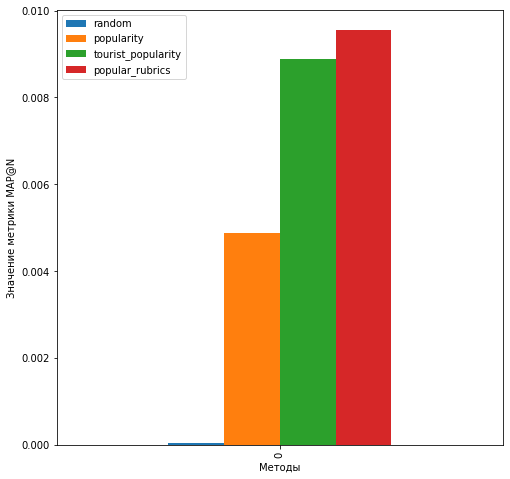

In [79]:
results_ax = pd.DataFrame([results]).plot(y=['random', 'popularity', 'tourist_popularity', 'popular_rubrics'], kind='bar', figsize=(8,8))
results_ax.set_xlabel('Методы')
results_ax.set_ylabel('Значение метрики MAP@N')

Источники
1. K. Falk, Practical recommender systems. Shelter Island, NY: Manning, 2019.
2. «Mean Average Precision (MAP) For Recommender Systems», Evening Session, 13:30:00-04:00 г. https://sdsawtelle.github.io/blog/output/./mean-average-precision-MAP-for-recommender-systems.html (просмотрено 5 июнь 2022 г.).
3. «Netflix Prize», Wikipedia. 16 апрель 2022 г. Просмотрено: 6 июнь 2022 г. [Онлайн]. Доступно на: https://en.wikipedia.org/w/index.php?title=Netflix_Prize&oldid=1083006521